# Signal Pre-processing

In [64]:
from jupyterthemes import jtplot
import pandas as pd
import numpy as np
import wfdb
from wfdb import processing
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import csv

In [39]:
# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='poster', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=True, figsize=(6, 4.5))

1. Subtract the mean from the data
2. Five order moving average filtering
3. high pass filtering with fc = 1 Hz (driftsuppression)
4. low-pass Butterworth filtering with fc = 30 Hz
5. Only the first channels of the MITDB and the VFDB have been considered to avoid dependency of samples during the learning process.

In [22]:
def signal_creator(MIT_signal_whole):
    MIT_data = []
    for i in range(len(MIT_signal_whole[0])):
        MIT_data.append(MIT_signal_whole[0][i][0])
    MIT_data = np.array(MIT_data)
    nulls = np.isnan(MIT_data)
    l=[]
    for i in range(len(nulls)):
        if nulls[i] == True:
            MIT_data[i] = 0
            l.append(i) 
    MIT_data[l] = np.mean(MIT_data)
    #plt.plot(MIT_data)
    #plt.xlim(0,600)
    return MIT_data


def moving_average(l, N):
    sum = 0
    result = list( 0 for x in l) 
    for i in range( 0, N ):
        sum = sum + l[i]
        result[i] = sum / (i+1)
    for i in range( N, len(l) ):
        sum = sum - l[i-N] + l[i]
        result[i] = sum / N
    return result

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def starting_point(signal,t,fs):
    M = np.amax(signal[0:300])
    index_M = np.where(signal==M)
    signal_start = signal[index_M[0][0]:-1]
    time_M = np.arange(signal_start.size)/fs
    return signal_start,time_M

def signal_preprocessor(data,time,uu,mm):
    mean = np.mean(data)
    data = data - mean
    
    data = moving_average(data,5)
    #plt.plot(time,data)
    #plt.xlim(0,10)
    data = np.array(data)
    
    data = butter_highpass_filter(data, 1, uu, 5)
    #figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.xlim((0, 10))
    #plt.plot(time,data)
    
    MIT_signal = butter_lowpass_filter(data, 1, mm, 5)
    fs=30
    time = np.arange(MIT_signal.size)/fs
    time = time/10
    #figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.xlim((0, 10))
    #plt.plot(time,MIT_signal)

    return MIT_signal,time

def ready_signal(directory,freq1):
    s = wfdb.io.rdsamp(directory)
    s = signal_creator(s)
    t = np.arange(s.size)/freq1
    s,t= signal_preprocessor(s,t,freq1,30)
    s = wfdb.processing.normalize_bound(s, lb=-1, ub=1)
    return s,t

def starting_point_end(signal,t):
    M = np.amax(signal[0:300])
    index_M = np.where(signal==M)
    signal_start = signal[index_M[0][0]:-1]
    time_M = t[index_M[0][0]:-1]
    return signal_start,time_M

def for_TCI(ss,tt):
    values = []
    time = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(ss[i][j])
            time.append(tt[i][j])
    return values,time

def start_end_ext(ss,tt):
    values = []
    time = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            x,y = starting_point_end(ss[i][j],tt[i][j])
            values.append(x)
            time.append(y)
    return values,time

def for_sigmar(s,t):
    sigs = []
    tims = []
    for i in s:
        x = np.array_split(i,int(len(i)/3300))
        sigs.append(x)
    for i in t:
        y = np.array_split(i,int(len(i)/3300))
        tims.append(y)
    return sigs,tims

## Signals and Times Arrays:

In [23]:
signals = []
times = []
str1 = "./Data_thesis/MIT/"
MIT_str = ["100","101","102","103","104","105","106","107","108","109","111","112","113","114","115","116","117","118","119",
           "121","122","123","124","200","201","202","203","205","207","208","209","210","212","213","214","215","217",
           "219","220","221","222","223","228","230","231","232","233","234"]
for i in MIT_str:
    x,y = ready_signal(str1+i,360)
    signals.append(x)
    times.append(y)
str2 = "./Data_thesis/CUDB/"
cudb_str = ["cu01","cu02","cu03","cu04","cu05","cu06","cu07","cu08","cu09","cu10","cu11","cu12","cu13","cu14","cu15","cu16",
            "cu17","cu18","cu19","cu20","cu21","cu22","cu23","cu24","cu25","cu26","cu27","cu28","cu29","cu30","cu31","cu32",
            "cu33","cu34","cu35"]
for i in cudb_str:
    x,y = ready_signal(str2+i,250)
    signals.append(x)
    times.append(y)
str3 = "./Data_thesis/VFDB/"
vfdb_str = ["418","419","420","421","422","423","424","425","426","427","428","429","430","602","605","607",
            "609","610","611","612","614","615"]
for i in vfdb_str:
    x,y = ready_signal(str3+i,250)
    signals.append(x)
    times.append(y)

In [24]:
ss,tt = for_sigmar(signals,times)

In [25]:
sm,tm = start_end_ext(ss,tt)

In [26]:
for i in range(0,105):
    for j in range(len(ss[i])):
        if len(ss[i][j])!=len(tt[i][j]):
            print("oops")    ##Checking if time and signal are the same size, and they are!

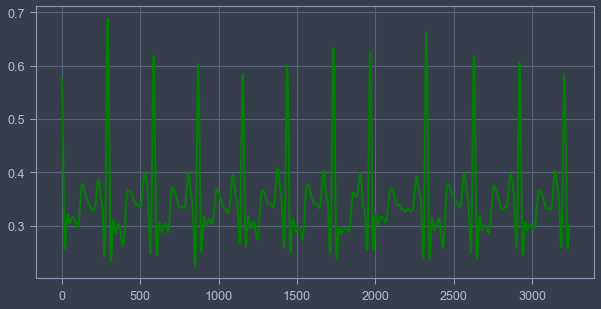

In [54]:
plt.figure(figsize=(10,5))
plt.plot(sm[0],color="green",linewidth=2)

In [59]:
x = pd.DataFrame(np.array(ss))

In [63]:
x[0][0]

[array([0.35859167, 0.35959884, 0.36067636, ..., 0.29531516, 0.30058315,
        0.30521341]),
 array([0.3090987 , 0.31217509, 0.31441872, ..., 0.29389431, 0.29590038,
        0.29828261]),
 array([0.30102896, 0.30411929, 0.30752547, ..., 0.38211178, 0.37731284,
        0.37261694]),
 array([0.36813761, 0.3639754 , 0.36021308, ..., 0.58605055, 0.60436623,
        0.61731722]),
 array([0.62454085, 0.62587278, 0.62135207, ..., 0.34466198, 0.34723607,
        0.34959095]),
 array([0.35171371, 0.35359715, 0.35523952, ..., 0.33960211, 0.33951418,
        0.33944684]),
 array([0.33944208, 0.33954495, 0.33980205, ..., 0.29599983, 0.2956684 ,
        0.29567848]),
 array([0.29600693, 0.29662169, 0.29748384, ..., 0.3529865 , 0.35202357,
        0.35108427]),
 array([0.35016774, 0.34927234, 0.34839613, ..., 0.26149241, 0.25268949,
        0.24528395]),
 array([0.23976637, 0.23662456, 0.23632208, ..., 0.31053439, 0.30870723,
        0.30632093]),
 array([0.3035373 , 0.30051639, 0.29741043, ..., 0

In [65]:
with open("sigfig.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows()

NameError: name 'a' is not defined

In [49]:
pd.DataFrame(np.array(sm)).to_csv("./Signal_Data/signals.csv",sep=',')
pd.DataFrame(np.array(tm)).to_csv("./Signal_Data/times.csv",sep=",")

In [55]:
pd.DataFrame(np.array(ss)).to_csv("./Signal_Data/signals_anns.csv",sep=',')
pd.DataFrame(np.array(tt)).to_csv("./Signal_Data/times_anns.csv",sep=",")